In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [86]:
data=pd.read_csv("/content/FIFA 2018 Statistics.csv")

data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [87]:
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

In [88]:
gc = np.array([], dtype = 'int')
for i in range(0, 128, 2):
    gc = np.append(gc, data.loc[i+1, "Goal Scored"])
    gc = np.append(gc, data.loc[i, "Goal Scored"])
    
data.insert(4, "Goal Conceded", pd.Series(gc))


In [89]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Goal Conceded,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,0,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,5,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [90]:
conditions = [(data["Goal Scored"] > data["Goal Conceded"]), (data["Goal Scored"] == data["Goal Conceded"]), (data["Goal Scored"] < data["Goal Conceded"])]
result = np.array([0, 1, 2], dtype = 'int')
data.insert(5, "Result", pd.Series(np.select(conditions, result, default = -1)))

In [91]:
data.insert(15, "Total Set Pieces", pd.Series(data["Corners"] + data["Free Kicks"], dtype = 'int'))

In [92]:
data.head(2)

,Date,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN


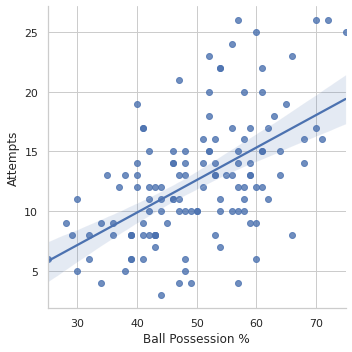

In [93]:
sns.lmplot(x = 'Ball Possession %', y = 'Attempts', data = data)

In [94]:
data["Ball Possession %"].corr(data["Attempts"], method = 'pearson')

0.5411851190090452

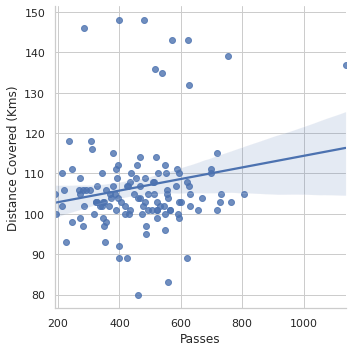

In [95]:
sns.lmplot(x = 'Passes', y = 'Distance Covered (Kms)', data = data)

In [96]:
data["Passes"].corr(data["Distance Covered (Kms)"], method = 'pearson')

0.18460146402248936

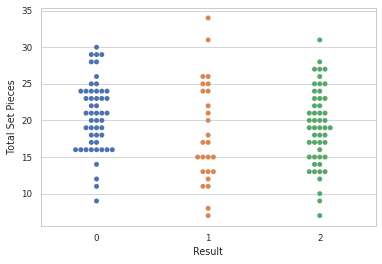

In [97]:
sns.set_context("paper")
sns.swarmplot( x = 'Result', y = 'Total Set Pieces', data = data)

In [98]:
#Dealing with Null Values
data.isna().sum()

Date                        0
Team                        0
Opponent                    0
Goal Scored                 0
Goal Conceded               0
Result                      0
Ball Possession %           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free Kicks                  0
Saves                       0
Total Set Pieces            0
Pass Accuracy %             0
Passes                      0
Distance Covered (Kms)      0
Fouls Committed             0
Yellow Card                 0
Yellow & Red                0
Red                         0
Man of the Match            0
1st Goal                   34
Round                       0
PSO                         0
Goals in PSO                0
Own goals                 116
Own goal Time             116
dtype: int64

In [99]:
data[['Own goals', 'Own goal Time']].head()

,Own goals,Own goal Time
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,1.0,90.0


As it can be seen, there were 116/2 = 58 matches in which either of the team did not score an own goal.
Therefore, I replace NaN with 0 in both the columns, as it seems to be the most logical idea.

In [100]:
data[['Own goals', 'Own goal Time']] = data[['Own goals', 'Own goal Time']].fillna(0)
data.isna().sum()

Date                       0
Team                       0
Opponent                   0
Goal Scored                0
Goal Conceded              0
Result                     0
Ball Possession %          0
Attempts                   0
On-Target                  0
Off-Target                 0
Blocked                    0
Corners                    0
Offsides                   0
Free Kicks                 0
Saves                      0
Total Set Pieces           0
Pass Accuracy %            0
Passes                     0
Distance Covered (Kms)     0
Fouls Committed            0
Yellow Card                0
Yellow & Red               0
Red                        0
Man of the Match           0
1st Goal                  34
Round                      0
PSO                        0
Goals in PSO               0
Own goals                  0
Own goal Time              0
dtype: int64

In [101]:
data["1st Goal"].head()

0    12.0
1     NaN
2     NaN
3    89.0
4     NaN
Name: 1st Goal, dtype: float64

These are the matches in which one of the teams were not able to score a single score.
Here, I replace NaN with full-time minutes as replacing it with 0 will give a different inference.

In [102]:
data["1st Goal"] = data["1st Goal"].fillna(90)
data.isna().sum()

Date                      0
Team                      0
Opponent                  0
Goal Scored               0
Goal Conceded             0
Result                    0
Ball Possession %         0
Attempts                  0
On-Target                 0
Off-Target                0
Blocked                   0
Corners                   0
Offsides                  0
Free Kicks                0
Saves                     0
Total Set Pieces          0
Pass Accuracy %           0
Passes                    0
Distance Covered (Kms)    0
Fouls Committed           0
Yellow Card               0
Yellow & Red              0
Red                       0
Man of the Match          0
1st Goal                  0
Round                     0
PSO                       0
Goals in PSO              0
Own goals                 0
Own goal Time             0
dtype: int64

Dealing with Categorical Variables

In [103]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [104]:
cat = data.columns.values[data.dtypes == object]
cat

array(['Date', 'Team', 'Opponent', 'Man of the Match', 'Round', 'PSO'],
      dtype=object)

Out of these features:

Date can be dropped.
1.Team and Opponent contain names of countries.
2.Man of the Match and PSO have values in Yes or No.
3.ound has 6 different values.
I'll deal with Team and Opponent separately.

In [105]:
data.drop(["Date"], axis = 1, inplace = True)

temp = np.array(['Man of the Match', 'Round', 'PSO'])
for i in range(0,len(temp)):
    x = temp[i]
    data[x] = data[x].astype('category').cat.codes
    
data.head(2)

,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,Russia,Saudi Arabia,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,1,12.0,2,0,0,0.0,0.0
1,Saudi Arabia,Russia,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,0,90.0,2,0,0,0.0,0.0


For Team and Opponent, I'll first get categorical codes for all the countries and then directly assign that codes to Team and Opponent.

In [106]:
# I am currently working on the above mentioned approach.
# This is a temporary solution.

data["Team"] = data["Team"].astype('category').cat.codes
data["Opponent"] = data["Opponent"].astype('category').cat.codes

In [107]:
data.head()

,Team,Opponent,Goal Scored,Goal Conceded,Result,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Total Set Pieces,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,23,24,5,0,0,40,13,7,3,3,6,3,11,0,17,78,306,118,22,0,0,0,1,12.0,2,0,0,0.0,0.0
1,24,23,0,5,2,60,6,0,3,3,2,1,25,2,27,86,511,105,10,0,0,0,0,90.0,2,0,0,0.0,0.0
2,8,31,0,1,2,43,8,3,3,2,0,1,7,3,7,78,395,112,12,2,0,0,0,90.0,2,0,0,0.0,0.0
3,31,8,1,0,0,57,14,4,6,4,5,1,13,3,18,86,589,111,6,0,0,0,1,89.0,2,0,0,0.0,0.0
4,17,13,0,1,2,64,13,3,6,4,5,0,14,2,19,86,433,101,22,1,0,0,0,90.0,2,0,0,1.0,90.0


Now our data is clean and ready to train.

In [108]:
features = data.drop(["Man of the Match"], axis = 1)
target = data["Man of the Match"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state = 7)

print(testx.shape)


trainx1 = pd.get_dummies(trainx, drop_first = True)
testx1 = pd.get_dummies(testx, drop_first = True)



testx1.columns.difference(trainx1.columns)

trainx1.columns.difference(testx1.columns)



(26, 28)


Index([], dtype='object')

#No alignment issues so going for model building

SVM

In [109]:
modelsvc = svm.SVC(kernel = 'rbf', gamma='auto')
modelsvc.fit(X_train, y_train)
y_svc = modelsvc.predict(X_test)
accuracy_score(y_test, y_svc)


0.48717948717948717

Logistic Regression

In [110]:
modelreg = linear_model.LogisticRegression()
modelreg.fit(X_train, y_train)
y_reg = modelreg.predict(X_test)
accuracy_score(y_test, y_reg.round(), normalize = False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



28

Random Forests Classifier

In [111]:
modelrf = RandomForestClassifier(max_depth=2, random_state=0)
modelrf.fit(X_train, y_train)
y_rf = modelrf.predict(X_test)
accuracy_score(y_test, y_rf)

0.8461538461538461

We obtain 84% accuracy using Random Forests Classifier.

Therefore, for this case, Random Forests Classifier prove to be the best classifier algorithm.